# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1QBEGPbTlKg0tkfTKjXFy4Hk-i7VvFyPe

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

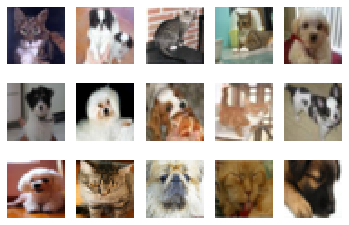

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print('Training Samples: ', len(train_loader))
print('Validation Samples: ', len(val_loader))
print('Validation Samples: ', len(test_loader))

Training Samples:  8000
Validation Samples:  2000
Validation Samples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

A validation set is required for avoiding overfitting and making sure that the model performs accurately on the test set in addition to the training set. Validation set is also used for hyperparameter tuning to increase accuracy of our results. 
If we judge the performance of our models using only the training set loss/error, the model will probably overfit and perform poorly on the test set.  

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)
print(" ")
for param in large_net.parameters():
    print(param.shape)

Total number of parameters in small set: (5)(3)(3)(3) + 5 + 245 + 1 = 386<br>
Total number of parameters in large set: (5)(3)(5)(5) + 5 + (10)(5)(5)(5) + 10 + (32)(250) + 32 + 32 + 1 = 9705



### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(model_path + "_train_err.csv" + "is written to disk")
    print(model_path + "_train_loss.csv" + "is written to disk")
    print(model_path + "_val_err.csv" + "is written to disk")
    print(model_path + "_val_loss.csv" + "is written to disk")


### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net,64, 0.01, 5)

There are 4 files written to disk:

model_small_bs64_lr0.01_epoch4_train_err.csvis: contains graphs and information about the error function of the training dataset. Error function contains the percentage of correct outputs in each epoch. 

model_small_bs64_lr0.01_epoch4_train_loss.csvis: contains graphs and information about the loss function of the training dataset, which allows optimizer to change parameters of the model. 

model_small_bs64_lr0.01_epoch4_val_err.csvis: contains graphs and information about error function of validation dataset.

model_small_bs64_lr0.01_epoch4_val_loss.csvis: contains graphs and information about loss function of validation dataset.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
train_net(small_net)

train_net(large_net)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.28425, Train loss: 0.5596658978462219 |Validation err: 0.3145, Validation loss: 0.5947019252926111
Epoch 2: Train err: 0.284875, Train loss: 0.5577362530231476 |Validation err: 0.3185, Validation loss: 0.5918586123734713
Epoch 3: Train err: 0.282125, Train loss: 0.5568766400814057 |Validation err: 0.3115, Validation loss: 0.5897681470960379
Epoch 4: Train err: 0.28075, Train loss: 0.5541636316776276 |Validation err: 0.3135, Validation loss: 0.590359540656209
Epoch 5: Train err: 0.2775, Train loss: 0.5508915545940399 |Validation err: 0.316, Validation loss: 0.5899350494146347
Epoch 6: Train err: 0.278875, Train loss: 0.5472624580860138 |Validation err: 0.313, Validation loss: 0.6029822723940015
Epoch 7: Train err: 0.281625, Train loss: 0.5517717592716217 |Validation err: 0.316, Validation loss: 0.5973315825685859
Epoch 8: Train err: 0.277125, Train loss: 0.5483883073329926 |Validation err: 

The total time to train the small network was 100.21 seconds, whereas the total time to train the large network was 115.68 seconds.
The training takes longer in the large network because of more parameters to update after each batch.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

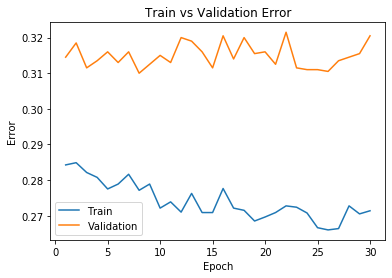

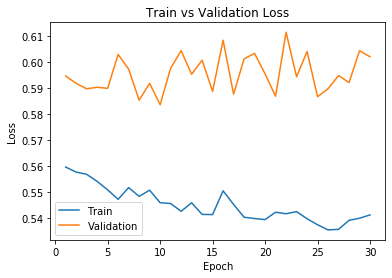

In [ ]:
model_pathSmall = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_pathSmall)

#SMALL MODEL

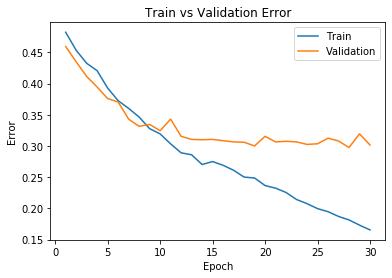

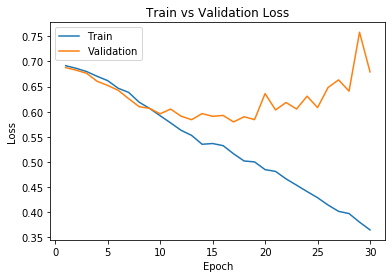

In [ ]:
model_pathLarge = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_pathLarge)

#LARGE MODEL

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The validation/training curves for the small and large network differ by their shape and value. 

Small Network:
Error seems to be similar in both validation and training curves. As for loss curve, underfitting is observable in the small network as performance on training set is better than on the validation set.

Large Network:
Error lowers for training set, but plateaus for the validation set. As the epoch increases the loss and error decreases for the training samples, yet increases for validation sameples. This is because of overfitting resulting from too many iterations of the samples. Signs of overfitting can be noticed in the large network as the validation loss reduces to an inflection point (at around 15 Epoch) and then starts to increase again. This is because the model becomes more specialized to training data, and it is unable to generalize to validation data as well. 


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

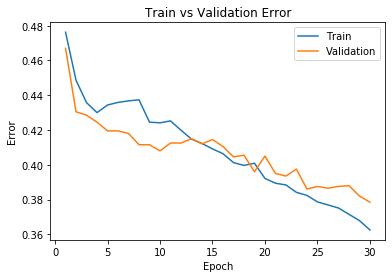

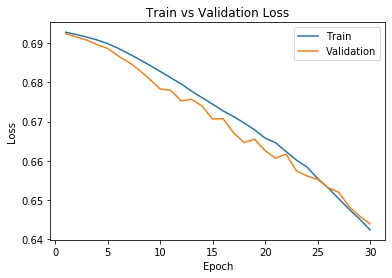

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, 64, 0.001, 30)

model_pathLarge = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_pathLarge)


Previous the model took 115.68 seconds to train, whereas now it takes 115.27 seconds to train. So it takes almost same time. Based on the plots, both the error and loss of validation and train decrease when the learning rate is decreased. As seen from the curve, the model seems to need more time to train, as the loss is decreasing but is still a very high value for both the train and validation sets after 30 Epochs. 

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

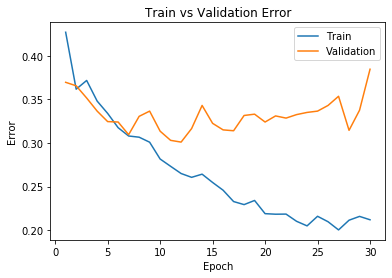

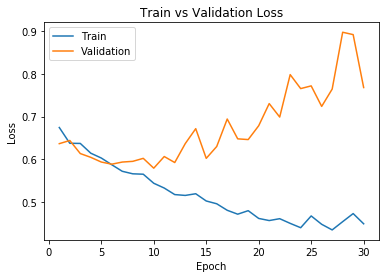

In [ ]:
large_net = LargeNet()

train_net(large_net, 64, 0.1, 30)

model_pathLarge = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_pathLarge)

The model took 114.23 seconds to train, which is slightly faster. With increasing the learning rate, the loss in validation dataset increases significantly as the epochs increase. This is because sub optimal weights are chosen by the algorithm, which learning rate is too high. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

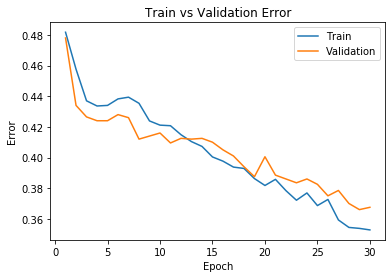

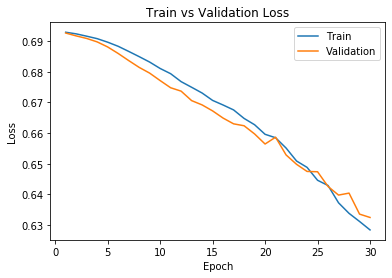

In [ ]:
large_net = LargeNet()

train_net(large_net, 512, 0.01, 30)

model_pathLarge = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_pathLarge)

The model takes 98.37 seconds to train, which is significantly lower than the 115.68 seconds time with batch size of 64. 
When we increase the batch size, it can be observed that the validation error and loss aligned with the training loss and error with a decreasing trend overall. However, even towards the end of 30 epochs, the loss value is still high. A larger batch size may lead to slow convergence towards optimal values during training. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

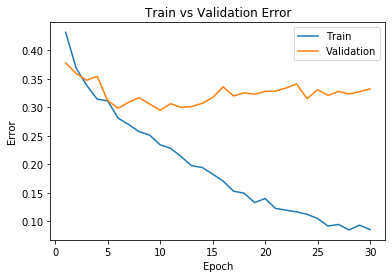

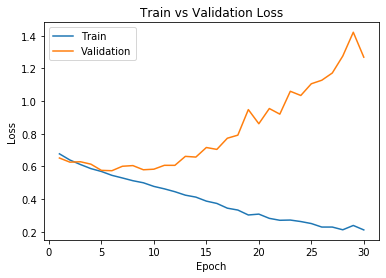

In [ ]:
large_net = LargeNet()

train_net(large_net, 16, 0.01, 30)

model_pathLarge = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_pathLarge)

This training process takes the longest with 185.09 seconds. 
When the batch size is lowered to 16, the loss for validation increases rapidly. At a lowered batch size, the parameters of our model are updated very frequently, causing overfitting. The validation function error plateaus whereas the validation loss function increases rapidly. This means that even though the right outcomes might be outputted, but the difference between the predictions and target labels is very high, due to overfitting.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

According to part 3, I would choose the following values:

Large Network, Batch size: 128, Learning rate: default (0.01)

I chose these values as the large network can handle more complexity due to more parameters. Further, I chose batch size 128 as it is a balance between 512 and 64, both of which proved to be extreme values in part 3, I can predict that this will lead to steady convergence to optimal results. 

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222535965934 |Validation err: 0.426, Validation loss: 0.6897580400109291
Epoch 2: Train err: 0.44475, Train loss: 0.6877933882531666 |Validation err: 0.4115, Validation loss: 0.6820726208388805
Epoch 3: Train err: 0.422, Train loss: 0.6812239989401803 |Validation err: 0.412, Validation loss: 0.6738845333456993
Epoch 4: Train err: 0.41025, Train loss: 0.6737808935225956 |Validation err: 0.4075, Validation loss: 0.6660195551812649
Epoch 5: Train err: 0.397, Train loss: 0.6661106366959829 |Validation err: 0.401, Validation loss: 0.6589444242417812
Epoch 6: Train err: 0.3765, Train loss: 0.6566641018504188 |Validation err: 0.389, Validation loss: 0.6511358879506588
Epoch 7: Train err: 0.374875, Train loss: 0.648662491450234 |Validation err: 0.3755, Validation loss: 0.6394486390054226
Epoch 8: Train err: 0.359125, Train loss: 0.636394875390189 |Validation err: 0.3685, 

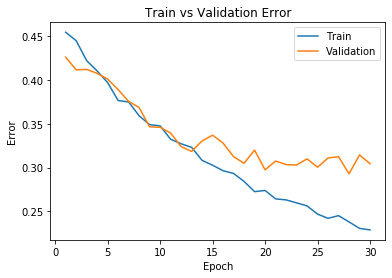

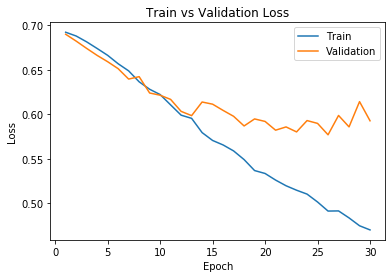

In [ ]:
large_net = LargeNet()

train_net(large_net, 128, 0.01, 30)

model_pathLarge = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_pathLarge)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Large Network, Batch size: 128, Learning rate: 0.0075

After multiple attempts to improve accuracy, I finally reached the value of 0.0075. Only the learning rate was changed to ensure that it does not get stuck in a local minima and start overfitting on training data, resulting in validation error. Decreasing it by an optimal amount would optimize the model. I arrived at a rate of 0.0075.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.457, Train loss: 0.6923038874353681 |Validation err: 0.4265, Validation loss: 0.6907913461327553
Epoch 2: Train err: 0.447875, Train loss: 0.6896396979453072 |Validation err: 0.4215, Validation loss: 0.6856206804513931
Epoch 3: Train err: 0.427875, Train loss: 0.6849463988864233 |Validation err: 0.4145, Validation loss: 0.6790960431098938
Epoch 4: Train err: 0.42, Train loss: 0.6792027874598427 |Validation err: 0.4075, Validation loss: 0.6716794930398464
Epoch 5: Train err: 0.41275, Train loss: 0.6737975241645934 |Validation err: 0.408, Validation loss: 0.667246475815773
Epoch 6: Train err: 0.398375, Train loss: 0.6677236907065861 |Validation err: 0.3895, Validation loss: 0.6633015125989914
Epoch 7: Train err: 0.388125, Train loss: 0.661126212468223 |Validation err: 0.391, Validation loss: 0.6547975242137909
Epoch 8: Train err: 0.380125, Train loss: 0.6539262712947906 |Validation err: 0.38

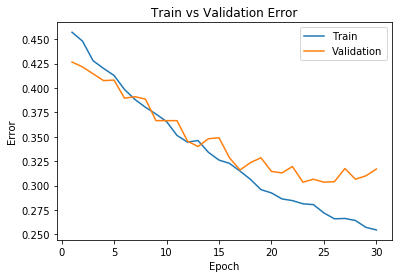

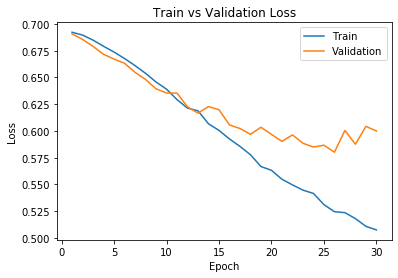

In [ ]:
large_net = LargeNet()

train_net(large_net, 128, 0.0075, 30)

model_pathLarge = get_model_name("large", batch_size=128, learning_rate=0.0075, epoch=29)
plot_training_curve(model_pathLarge)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(net, batch_size=128, learning_rate=0.0075, num_epochs=24)
model_path = get_model_name('large', batch_size=128, learning_rate=0.0075, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.457, Train loss: 0.6923038874353681 |Validation err: 0.4265, Validation loss: 0.6907913461327553
Epoch 2: Train err: 0.447875, Train loss: 0.6896396979453072 |Validation err: 0.4215, Validation loss: 0.6856206804513931
Epoch 3: Train err: 0.427875, Train loss: 0.6849463988864233 |Validation err: 0.4145, Validation loss: 0.6790960431098938
Epoch 4: Train err: 0.42, Train loss: 0.6792027874598427 |Validation err: 0.4075, Validation loss: 0.6716794930398464
Epoch 5: Train err: 0.41275, Train loss: 0.6737975241645934 |Validation err: 0.408, Validation loss: 0.667246475815773
Epoch 6: Train err: 0.398375, Train loss: 0.6677236907065861 |Validation err: 0.3895, Validation loss: 0.6633015125989914
Epoch 7: Train err: 0.388125, Train loss: 0.661126212468223 |Validation err: 0.391, Validation loss: 0.6547975242137909
Epoch 8: Train err: 0.380125, Train loss: 0.6539262712947906 |Validation err: 0.38

<All keys matched successfully>

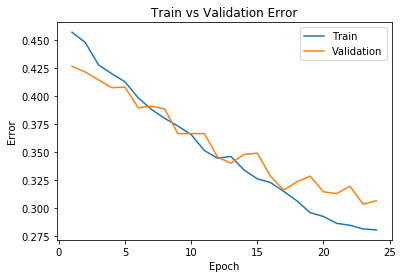

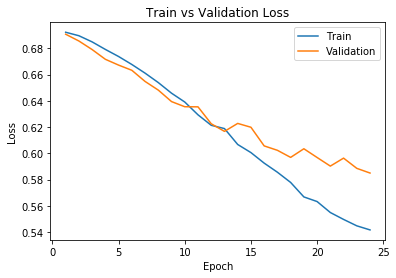

In [ ]:
plot_training_curve(model_path)

### Part (b) - 2pt

Justify your choice of model from part (a).

learning_rate = 0.0075
batch_size = 128
epochs = 24
Network = large

I chose first 3 parameters from part 4c) as for the reasons described previously. I lowered the number of epochs to 24 as that number seemed to control overfitting and it is the point where loss for validation forms a plateau. 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

val_err, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())

test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())

print('Validation Error: ', val_err)
print('Test Error: ', test_err)


Files already downloaded and verified
Files already downloaded and verified
Validation Error:  0.3065
Test Error:  0.3035


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The validation error is higher than the test error. I would rather expect the test error to be higher because specific hyperparameters were chosen which would lower validation error to provide optimal outcome for the model on new (test) data. Since our model has never seen test data before and parameters have not been catered towards thi sdata, we would expect test error to be higher, which was not. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We used the test data at the end to judge the performance of our model. If the test data would be used at the beginning, then the model would overfit to that data to achieve full accuracy. We use test data as little as possible to avoid losing data for testing purposes, which is required to make sure that the model performs well.

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network

class smallANN(nn.Module):
    def __init__(self):
        super(smallANN, self).__init__()
        self.name="small"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

In [ ]:
smallANN = smallANN()
train_net(smallANN, batch_size=250, learning_rate=0.0033, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43875, Train loss: 0.6804020926356316 |Validation err: 0.417, Validation loss: 0.6675704568624496
Epoch 2: Train err: 0.397625, Train loss: 0.6624854803085327 |Validation err: 0.3995, Validation loss: 0.659895196557045
Epoch 3: Train err: 0.38875, Train loss: 0.6542807370424271 |Validation err: 0.401, Validation loss: 0.6558976694941521
Epoch 4: Train err: 0.382625, Train loss: 0.6488595511764288 |Validation err: 0.393, Validation loss: 0.6528141051530838
Epoch 5: Train err: 0.374375, Train loss: 0.6435895301401615 |Validation err: 0.3935, Validation loss: 0.6507685407996178
Epoch 6: Train err: 0.371375, Train loss: 0.6395776886492968 |Validation err: 0.3855, Validation loss: 0.6498855575919151
Epoch 7: Train err: 0.365125, Train loss: 0.6360448934137821 |Validation err: 0.385, Validation loss: 0.6488006338477135
Epoch 8: Train err: 0.362625, Train loss: 0.6321400329470634 |Validation err:

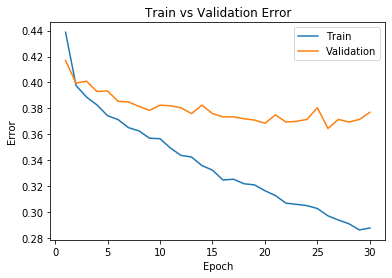

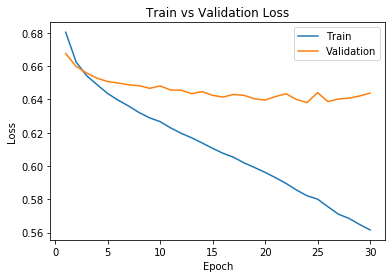

In [ ]:
ANN_path = get_model_name("small", batch_size=250, learning_rate=0.0033, epoch=29)
plot_training_curve(ANN_path)

In [ ]:
test_err, test_loss = evaluate(smallANN, test_loader, nn.BCEWithLogitsLoss())
print('Test Error:',test_err)
print('Test Loss:', test_loss)

Test Error: 0.366
Test Loss: 0.6408968809992075


In an overall analysis, the CNN can be found to perform better than the ANN model, as noticed in the validation/test error and loss graphs.